In [155]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import sys
import itertools
import datetime
import odc.algo
from copy import deepcopy
import warnings

sys.path.append('../Scripts')
from dea_plotting import rgb



    
dc = datacube.Datacube(app='Using_load_ard')

# Load ard params
products = ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']
min_gooddata = 0.9
ls7_slc_off = False
mask_contiguity='nbart_contiguity'
dcload_kwargs = {
    'x': (153.38, 153.47),
    'y': (-28.83, -28.92),
    'time': ('2018-01', '2018-12'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {}
}



# To prevent modifications to dcload_kwargs being made by this 
# function remaining after the function is run (potentially causing 
# different results each time the function is run), first take a 
# deep copy of the dcload_kwargs object. 
dcload_kwargs = deepcopy(dcload_kwargs)  

# Determine if lazy loading is required
lazy_load = 'dask_chunks' in dcload_kwargs

# Warn user if they combine lazy load with min_gooddata
if (min_gooddata > 0.0) & lazy_load:
            warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "
                          "will cause dask arrays to compute when "
                          "loading pixel-quality data to calculate "
                          "'good pixel' percentage. This can "
                          "significantly slow the return of your dataset.")

# Verify that products were provided, and that only Sentinel-2 or 
# only Landsat products are being loaded at the same time
if not products:
    raise ValueError("Please provide a list of product names "
                     "to load data from. Valid options are: \n"
                     "['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] " 
                     "for Landsat, ['s2a_ard_granule', "
                     "'s2b_ard_granule'] \nfor Sentinel 2 Definitive, or "
                     "['s2a_nrt_granule', 's2b_nrt_granule'] for "
                     "Sentinel 2 Near Real Time")
elif all(['ls' in product for product in products]):
    product_type = 'ls'
elif all(['s2' in product for product in products]):
    product_type = 's2'
else:
    raise ValueError("Loading both Sentinel-2 and Landsat data "
                     "at the same time is currently not supported")

# If `measurements` are specified but do not include fmask or 
# contiguity variables, add these to `measurements`
to_drop = []  # store loaded var names here to later drop
fmask_band = 'fmask'

if 'measurements' in dcload_kwargs:        

    if fmask_band not in dcload_kwargs['measurements']:
        dcload_kwargs['measurements'].append(fmask_band)
        to_drop.append(fmask_band)

    if (mask_contiguity and 
        (mask_contiguity not in dcload_kwargs['measurements'])):
        dcload_kwargs['measurements'].append(mask_contiguity)
        to_drop.append(mask_contiguity)  

# If no `measurements` are specified, Landsat ancillary bands are loaded
# with a 'oa_' prefix, but Sentinel-2 bands are not. As a work-around, 
# we need to rename the default contiguity and fmask bands if loading
# Landsat data without specifying `measurements`
elif product_type == 'ls': 
    mask_contiguity = f'oa_{mask_contiguity}' if mask_contiguity else False
    fmask_band = f'oa_{fmask_band}' 

    
    
    
# Extract datasets for each product using subset of dcload_kwargs
dataset_list = []
datasets_query = {k:v for k,v in dcload_kwargs.items() 
                  if k in ['time', 'x', 'y']}

# Get list of datasets for each product
for product in products:    

    # Obtain list of datasets for product
    print(f'Finding {product} data')
    datasets = dc.find_datasets(product=product, **datasets_query)    
    
    # Remove Landsat 7 SLC-off observations if ls7_slc_off=False
    if not ls7_slc_off and product == 'ga_ls7e_ard_3':
        print('    Ignoring SLC-off observations for ls7')
        datasets = [i for i in datasets if i.time.begin < 
                    datetime.datetime(2003, 5, 31)]
        
    # Add any returned datasets to list
    dataset_list.extend(datasets)

# If dask_chunks is specified, load data using dcload_kwargs only
if lazy_load:
    ds = dc.load(datasets=dataset_list,
                 **dcload_kwargs)
                
# If no dask chunks specified, add this param so that
# we can lazy load data before filtering by good data
else:
    ds = dc.load(datasets=dataset_list,
                 dask_chunks={},
                 **dcload_kwargs) 
    
# Generate good quality data mask
good_quality = odc.algo.fmask_to_bool(mask=ds[fmask_band], 
                                      categories=('valid', 'snow', 'water'))
ds_clean = odc.algo.keep_good_only(ds, where=good_quality)
ds_clean = odc.algo.to_f32(ds_clean)

# The good data percentage calculation has to load in all `fmask`
# data, which can be slow. If the user has chosen no filtering 
# by using the default `min_gooddata = 0`, we can skip this step 
# completely to save processing time
if min_gooddata > 0.0:

    # Compute good data for each observation as % of total pixels
    data_perc = (good_quality.sum(axis=[1, 2], dtype='int32') / 
                 (good_quality.shape[1] * good_quality.shape[2]))

    # Filter by `min_gooddata` to drop low quality observations
    total_obs = len(ds.time)
    ds = ds.sel(time=data_perc >= min_gooddata)
    print(f'Filtering to {len(ds.time)} out of {total_obs} '
          f'observations with at least {min_gooddata:.0%} '
          f'good quality pixels')

# Drop bands not originally requested by user
ds = ds.drop(to_drop)
print(ds)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.


Finding ga_ls5t_ard_3 data
Finding ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
Finding ga_ls8c_ard_3 data
Filtering to 5 out of 41 observations with at least 90% good quality pixels)
<xarray.Dataset>
Dimensions:      (time: 5, x: 342, y: 380)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-11T23:41:34.411931 ... 2018-08-15T23:41:57.559775
  * y            (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * x            (x) float64 2.05e+06 2.051e+06 ... 2.061e+06 2.061e+06
Data variables:
    nbart_red    (time, y, x) int16 dask.array<chunksize=(1, 380, 342), meta=np.ndarray>
    nbart_green  (time, y, x) int16 dask.array<chunksize=(1, 380, 342), meta=np.ndarray>
    nbart_blue   (time, y, x) int16 dask.array<chunksize=(1, 380, 342), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577


In [148]:
dc.find_datasets(product='ga_ls5t_ard_3', **datasets_query)    

[]

In [147]:
product

'ga_ls7e_ard_3'

In [ ]:
product

In [120]:
good_quality.sum(dim='time', dtype='int16').compute()

# (good_quality.shape[1] * good_quality.shape[2])

<xarray.DataArray 'fmask' (y: 380, x: 342)>
array([[13, 13, 14, ..., 12, 12, 12],
       [14, 14, 14, ..., 13, 12, 12],
       [14, 14, 14, ..., 13, 13, 13],
       ...,
       [11, 11, 11, ..., 22, 21, 21],
       [11, 11, 11, ..., 21, 21, 21],
       [11, 11,  9, ..., 21, 21, 21]], dtype=int16)
Coordinates:
  * y        (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * x        (x) float64 2.05e+06 2.051e+06 2.051e+06 ... 2.061e+06 2.061e+06

In [112]:
(ds.nbart_red > 400).sum(dtype='int16')

<xarray.DataArray 'nbart_red' ()>
dask.array<sum-aggregate, shape=(), dtype=int16, chunksize=(), chunktype=numpy.ndarray>

In [134]:
(good_quality.sum(axis=1, dtype='int32').sum(axis=1, dtype='int32') / 
(good_quality.shape[1] * good_quality.shape[2]))
 
 
#  .count(axis=1, dtype='int16').sum(axis=1, dtype='int16')).compute()


<xarray.DataArray 'fmask' (time: 41)>
dask.array<truediv, shape=(41,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-12-30T23:36:12.905770

In [139]:
good_quality.sum(axis=[1, 2], dtype='int32').compute()

<xarray.DataArray 'fmask' (time: 41)>
array([114936,   4247,  36219,     13,      6,    226,  86511,  66595,
            0, 114346,    275, 129958,   1860,  25259,      0,   6617,
         9628, 129960,   8631, 129956,   4317, 129960,   7085, 129960,
            0, 115155,   4685,  22653,   1303,  69282,      0,    293,
            0,      0,    218, 107753,   7033,  28634,      0,    981,
          186], dtype=int32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-12-30T23:36:12.905770

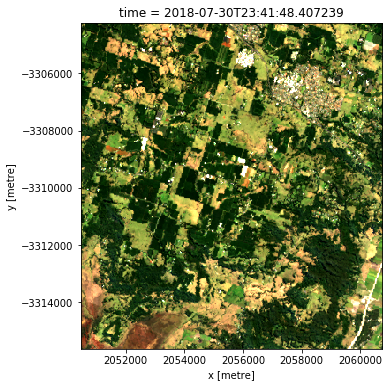

In [95]:
rgb(ds, index=3)

In [ ]:
                # Compute good data for each observation as % of total pixels
                data_perc = (good_quality.sum(axis=1).sum(axis=1) / 
                    (good_quality.shape[1] * good_quality.shape[2]))

                # Filter by `min_gooddata` to drop low quality observations
                ds = ds.sel(time=data_perc >= min_gooddata)
                print(f'    Filtering to {len(ds.time)} '
                      f'out of {total_obs} observations')

In [82]:
no_cloud.sum(dim='time')

<xarray.DataArray 'fmask' (y: 380, x: 342)>
dask.array<sum-aggregate, shape=(380, 342), dtype=int64, chunksize=(380, 342), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * x        (x) float64 2.05e+06 2.051e+06 2.051e+06 ... 2.061e+06 2.061e+06

In [2]:
# Extract datasets for each product
dataset_list = [dc.find_datasets(product=product, **query) 
                for product in products]
    
# Combine into one list
dataset_list = itertools.chain.from_iterable(dataset_list)

ds = dc.load(datasets=dataset_list, **query)




# Test data load
query = {
#     'x': (153.38, 153.47),
#     'y': (-28.83, -28.92),
#     'time': ('2018-04', '2018-06'),
#     'measurements': ['nbart_green'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

ds = dc.load(datasets=dataset_list, **query)

KeyboardInterrupt: 

In [5]:


post_da = dc.load(product=products[2], **query)





In [9]:
post_da.isel(time=0)

<xarray.Dataset>
Dimensions:      (x: 342, y: 380)
Coordinates:
    time         datetime64[ns] 2018-04-09T23:41:53.337775
  * y            (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
  * x            (x) float64 2.05e+06 2.051e+06 ... 2.061e+06 2.061e+06
Data variables:
    nbart_red    (y, x) int16 528 560 632 606 832 1192 ... 591 597 617 597 570
    nbart_green  (y, x) int16 774 815 901 820 1009 1333 ... 840 838 787 693 663
    nbart_blue   (y, x) int16 613 632 679 674 803 1078 ... 655 660 658 650 656
Attributes:
    crs:      EPSG:3577

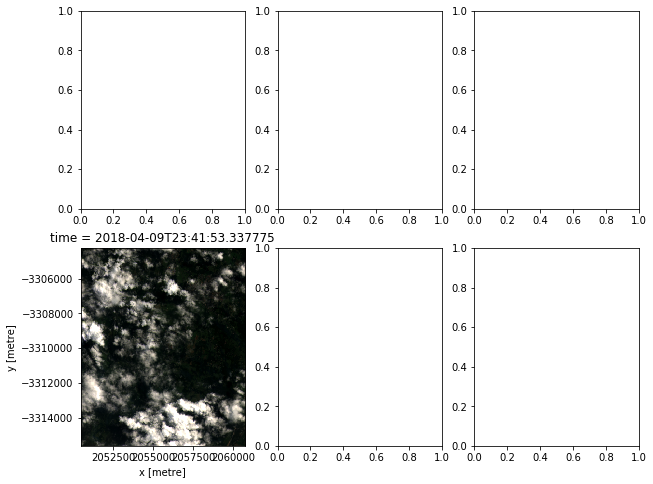

In [10]:
f, axarr = plt.subplots(2,3,figsize=(10,8),squeeze=False)
# axarr[0,0].imshow(baseline_NBR,cmap='RdBu',vmin=-1, vmax=1)
# axarr[0,0].set_title('Baseline NBR')
# axarr[0,1].imshow(post_NBR.NBR,cmap='RdBu',vmin=-1, vmax=1)
# axarr[0,1].set_title('Post-fire NBR')
# axarr[0,2].imshow(delta_NBR,cmap='RdBu_r',vmin=-1, vmax=1)
# axarr[0,2].set_title('Delta NBR')
# axarr[1,1].imshow(burnt)
# axarr[1,1].set_title('Burnt area')
# axarr[1,2].imshow(masked,cmap='RdBu_r',vmin=-1, vmax=1)
# axarr[1,2].set_title('Burnt area masked')
rgb(post_da.isel(time=0), bands=['nbart_red', 'nbart_green', 'nbart_blue'], ax=axarr[1,0])

